In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
print(tf.keras.__version__)

2.9.0


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/4.2/soft computing/Sentiment Analysis/bert multiclass classification/Sentiment_Binary.csv',encoding='UTF-8')

In [ ]:
data.head()

,Unnamed: 0,Comment,Tag
0,15634,বালের নাটক,0
1,688,জনগণের করের টাকায় বাজেট আর গৃহনির্মাণ খাতে জনগ...,1
2,22825,ওনেক সুন্দরর নাটক,1
3,7617,এক নম্বর ঠিক করলে বাকি দুইটা ঠিক হয়ে যাবে,1
4,2517,ফরম পূরণের আগে মন্ত্রণালয়ের উচিত মোট টাকার পরি...,1


In [ ]:
print(f'Total number of Documents: {len(data)}')

Total number of Documents: 22967


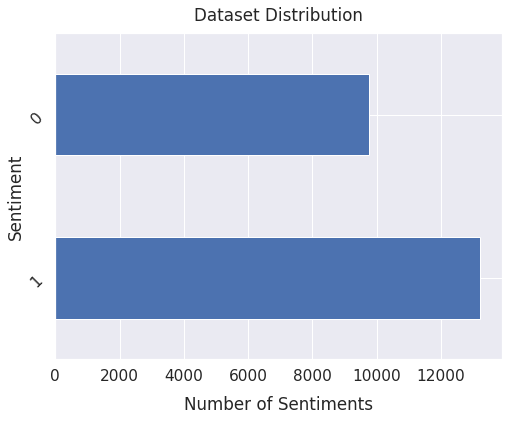

In [ ]:
# Plot the Class distribution
sns.set(font_scale=1.4)
data['Tag'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Sentiments", labelpad=12)
plt.ylabel("Sentiment", labelpad=3)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
path = '/content/drive/MyDrive/4.2/soft computing/Sentiment Analysis/'

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open(path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [ ]:
data['cleaned'] = data['Comment'].apply(cleaning_documents)  

In [ ]:
# Stopwords pickle 
stp = open(path+'bangla_stopwords.txt','r',encoding='utf-8').read().split()
# open a file, where you ant to store the data
file = open(path+'bangla_stopwords.pkl', 'wb')
# dump information to that file
pickle.dump(stp, file)

In [ ]:
# Calculate the Length of each Document
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = data.loc[data.Length<20]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 3248 Small Documents 
Total Remaining Documents: 19719


In [ ]:
dataset.to_csv(path+'cleaned_news.csv')

In [ ]:
#dataset = pd.read_csv('/content/drive/MyDrive/4.2/soft computing/Sentiment Analysis/balaced_cleaned_news.csv')
dataset = pd.read_csv(path+'cleaned_news.csv')
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Comment', 'Tag', 'cleaned', 'Length'], dtype='object')

In [ ]:
dataset = dataset.sample(frac=1)
dataset.shape

(19719, 6)

In [ ]:
dataset.head(6)

,Unnamed: 0,Unnamed: 0.1,Comment,Tag,cleaned,Length
18373,18373,14488,ফালতু হদিন,0,ফালতু হদিন,2
16681,16681,1338,কে শুনে কার কথা,0,শুনে কার কথা,3
14802,14802,3449,"পৃথিবীকে আর কতো টুকরো করলে,আপনাদের মতো মানুষরা...",0,পৃথিবীকে কতো টুকরো আপনাদের মানুষরা শান্তি পাবে,7
218,218,17841,নাটক টা সব দিক দিয়ে অনেক সুন্দর ছিল।নিশো ভাই ...,1,নাটক টা দিক দিয়ে সুন্দর নিশো ভাই নাটক সময় ভাল ...,11
8422,8422,2328,আমাদের লোক অনেক,1,লোক,1
11674,11674,20887,অনেক অনেক সুন্দর,1,সুন্দর,1


In [ ]:
dataset['Tag'].value_counts()

1    11486
0     8233
Name: Tag, dtype: int64

In [ ]:
def dataset_split(news,category):
  '''
  This function will split the dataset into Train-Test-Validation set

  Args:
  news: encoded texts
  category: class names

  returns:
  X_train: Encoded Training News  
  X_valid: Encoded Validation News
  X_test:  Encoded Test news
  y_train: Encoded Training labels
  y_valid: Encoded Validation labels
  y_test:  Encoded Test labels
  '''

  X,X_test,y,y_test = train_test_split(news,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
  X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
  print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
  print(color.BOLD+"\nDataset Distribution:\n"+color.END)
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",news.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])
  
  return X_train,X_valid,X_test,y_train,y_valid,y_test

In [ ]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words 

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''
  
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='', document_count=0)
  
 

 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned.astype(str))
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )    
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned.astype(str))
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  print(dataset.cleaned[6],"\n",sequences[6]) 

  #==================================== Pad Sequences ============================== 
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[6],"\n",corpus[6])   

  #=================================     Label Encoding ================================
  labels = dataset.Tag #label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open(path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels
  
#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                100,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
নাটক 	 3950
ভালো 	 2100
অসাধারণ 	 1438
একটা 	 1315
সুন্দর 	 1183
ভাই 	 1070
ভাল 	 935
টা 	 727
কথা 	 673
লাগলো 	 609

Words --> Documents:
নাটক 	 3567
ভালো 	 1923
অসাধারণ 	 1365
একটা 	 1267
সুন্দর 	 1084
ভাই 	 980
ভাল 	 859
টা 	 680
কথা 	 637
লাগলো 	 598

Words --> Index:
ঘেয়েমি 	 26891
হয়নিসেই 	 26890
দাওয়াতটা 	 26889
আলতু 	 26888
চাষে 	 26887
সাধারণভাবে 	 26886
গ্রামবাসীরা 	 26885
খুজতেই 	 26884
চুরিটা 	 26883
প্রেন্ড 	 26882

Total Documents --> 19719

			====== Encoded Sequences ====== 
Found 26891 unique tokens
বিজয়ের দিনে আমাদেরকে শপথ জুলুমবাজ সরকারকে সমর্থন করব 
 [1, 1660, 261]

			====== Paded Sequences ======
 বিজয়ের দিনে আমাদেরকে শপথ জুলুমবাজ সরকারকে সমর্থন করব 
 [   1 1660  261    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(corpus,labels)

Feature Size :======> 100

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 19719 
	Training		 14197 
	Test			 1972 
	Validation		 3550


In [ ]:
embedding_dimension = 128
input_length = 100
vocab_size = 5000
num_classes = 2
batch_size = 64
num_epochs = 5

accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 


In [ ]:
                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 19, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 19, 128)          98816     
 nal)                                                            
                                                      

In [ ]:
yhat_probs = model.predict(X_test,verbose=0)
#yhat_classes = model.predict_classes(X_test, verbose=0)

In [ ]:
y_preds=np.array(yhat_probs)

In [ ]:
y_test

2719     1
18742    1
14356    1
5091     0
16590    1
        ..
3194     1
18213    1
8261     1
18596    1
18916    1
Name: Tag, Length: 1972, dtype: int64

In [ ]:
yhat_probs

array([[6.1907638e-05, 9.9993807e-01],
       [9.9757707e-01, 2.4228399e-03],
       [3.1437381e-04, 9.9968565e-01],
       ...,
       [3.2432025e-04, 9.9967575e-01],
       [4.9587787e-05, 9.9995041e-01],
       [9.9135342e-04, 9.9900872e-01]], dtype=float32)

In [ ]:
y_preds

array([[6.1907638e-05, 9.9993807e-01],
       [9.9757707e-01, 2.4228399e-03],
       [3.1437381e-04, 9.9968565e-01],
       ...,
       [3.2432025e-04, 9.9967575e-01],
       [4.9587787e-05, 9.9995041e-01],
       [9.9135342e-04, 9.9900872e-01]], dtype=float32)

In [ ]:
print(confusion_matrix(y_test, y_preds))

In [ ]:
print(accuracy_score(y_test, y_preds))

In [ ]:
print(classification_report(y_test, y_preds, digits=3))

              precision    recall  f1-score   support

           0      0.427     1.000     0.599       843
           1      0.000     0.000     0.000       899
           2      0.000     0.000     0.000       230

    accuracy                          0.427      1972
   macro avg      0.142     0.333     0.200      1972
weighted avg      0.183     0.427     0.256      1972



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
